In [1]:
"""
class SpectrumDataset:
    def __init__(self, db_path='spectra.db', limit=None):
        self.conn = sqlite3.connect(db_path)
        self.cursor = self.conn.cursor()
        self.limit = limit
        self.molecules = []
        self.spectra = []
        self.load_data()

    def load_data(self):
        # Get total number of molecules
        self.cursor.execute("SELECT COUNT(*) FROM Molecules WHERE state='gas'")
        n_molecules = self.cursor.fetchone()[0]
        print(f"Total number of gas-state molecules: {n_molecules}")

        # Fetch molecules
        query = '''
            SELECT m.id, m.title, m.names
            FROM Molecules m
            WHERE m.state = 'gas'
        '''
        if self.limit:
            query += f' LIMIT {self.limit}'
        
        self.cursor.execute(query)
        molecules = self.cursor.fetchall()

        # Fetch spectrum data for each molecule
        for mol_id, title, names in molecules:
            self.cursor.execute('''
                SELECT x, y FROM SpectrumData
                WHERE molecule_id = ?
                ORDER BY x
            ''', (mol_id,))
            spectrum_data = self.cursor.fetchall()
            
            if spectrum_data:
                x_values, y_values = zip(*spectrum_data)
                self.molecules.append((mol_id, title, names))
                self.spectra.append((np.array(x_values), np.array(y_values)))

        print(f"Loaded {len(self.molecules)} molecules with spectrum data")

    def __len__(self):
        return len(self.molecules)




    def __getitem__(self, idx):
        mol_id, title, names = self.molecules[idx]
        x_values, y_values = self.spectra[idx]
        return {
            'mol_id': mol_id,
            'title': title,
            'names': names,
            'x_values': x_values,
            'y_values': y_values
        }

    def __del__(self):
        self.conn.close()

# Create an instance of the dataset
dataset = SpectrumDataset(limit=10)  # Limit to 100 molecules for testing


"""

'\nclass SpectrumDataset:\n    def __init__(self, db_path=\'spectra.db\', limit=None):\n        self.conn = sqlite3.connect(db_path)\n        self.cursor = self.conn.cursor()\n        self.limit = limit\n        self.molecules = []\n        self.spectra = []\n        self.load_data()\n\n    def load_data(self):\n        # Get total number of molecules\n        self.cursor.execute("SELECT COUNT(*) FROM Molecules WHERE state=\'gas\'")\n        n_molecules = self.cursor.fetchone()[0]\n        print(f"Total number of gas-state molecules: {n_molecules}")\n\n        # Fetch molecules\n        query = \'\'\'\n            SELECT m.id, m.title, m.names\n            FROM Molecules m\n            WHERE m.state = \'gas\'\n        \'\'\'\n        if self.limit:\n            query += f\' LIMIT {self.limit}\'\n        \n        self.cursor.execute(query)\n        molecules = self.cursor.fetchall()\n\n        # Fetch spectrum data for each molecule\n        for mol_id, title, names in molecules:\n    

In [2]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from pyCheckmol import CheckMol
import numpy as np
cm = CheckMol()



In [3]:
"""
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Connect to database
conn = sqlite3.connect('final.db')
cursor = conn.cursor()

# Fetch molecules with limit and join with spectrum data in a single query
limit = None
query = '''
    SELECT m.id, m.name, m.smiles, 
           GROUP_CONCAT(s.wavelength) as wavelengths,
           GROUP_CONCAT(s.intensity) as intensities
    FROM Molecules m
    LEFT JOIN SpectrumData s ON m.id = s.molecule_id
    WHERE m.smiles IS NOT NULL
    GROUP BY m.id
'''
if limit:
    query += f' LIMIT {limit}'

molecules_df = pd.read_sql_query(query, conn)

# Initialize lists
spectra_x = []
spectra_y = []
functional_groups = []
valid_indices = []

# Process molecules in batch
for idx, row in molecules_df.iterrows():
    # Convert string wavelengths/intensities to numpy arrays
    if pd.notna(row['wavelengths']):
        wavelengths = np.fromstring(row['wavelengths'], sep=',')
        intensities = np.fromstring(row['intensities'], sep=',')
        
        # Get functional groups
        cm = CheckMol()
        fg_data = cm.functionalGroupSmiles(smiles=row['smiles'], isString=True, generate3D=False,
                                         justFGcode=False, returnDataframe=False, deleteTMP=False)
        
        if fg_data:
            spectra_x.append(wavelengths)
            spectra_y.append(intensities)
            functional_groups.append(fg_data['Functional Group'])
            valid_indices.append(idx)

# Keep only valid rows
molecules_df = molecules_df.iloc[valid_indices]

# Add spectrum and functional group data
molecules_df['x_values'] = spectra_x
molecules_df['y_values'] = spectra_y
molecules_df['functional_groups'] = functional_groups

# Drop the concatenated columns
molecules_df = molecules_df.drop(['wavelengths', 'intensities'], axis=1)

print(f"Loaded {len(molecules_df)} molecules with spectrum data and functional groups")

# Close database connection
conn.close()

# Create dataset dictionary for easy access
dataset = molecules_df.to_dict('records')


"""

'\nimport sqlite3\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torch\nimport pandas as pd\n\n# Connect to database\nconn = sqlite3.connect(\'final.db\')\ncursor = conn.cursor()\n\n# Fetch molecules with limit and join with spectrum data in a single query\nlimit = None\nquery = \'\'\'\n    SELECT m.id, m.name, m.smiles, \n           GROUP_CONCAT(s.wavelength) as wavelengths,\n           GROUP_CONCAT(s.intensity) as intensities\n    FROM Molecules m\n    LEFT JOIN SpectrumData s ON m.id = s.molecule_id\n    WHERE m.smiles IS NOT NULL\n    GROUP BY m.id\n\'\'\'\nif limit:\n    query += f\' LIMIT {limit}\'\n\nmolecules_df = pd.read_sql_query(query, conn)\n\n# Initialize lists\nspectra_x = []\nspectra_y = []\nfunctional_groups = []\nvalid_indices = []\n\n# Process molecules in batch\nfor idx, row in molecules_df.iterrows():\n    # Convert string wavelengths/intensities to numpy arrays\n    if pd.notna(row[\'wavelengths\']):\n        wavelengths = np.fromstring(row[\'waveleng

# Faster!!

In [4]:

"""
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Connect to database
conn = sqlite3.connect('final.db')
cursor = conn.cursor()

# Fetch molecules with limit
limit = 100
query = '''
    SELECT m.id, m.name, m.smiles 
    FROM Molecules m
'''
if limit:
    query += f' LIMIT {limit}'

molecules_df = pd.read_sql_query(query, conn)

# Initialize lists to store spectrum data
spectra_x = []
spectra_y = []
functional_groups = []

# Fetch spectrum data and functional groups for each molecule
for idx, row in molecules_df.iterrows():
    mol_id = row['id']
    smiles = row['smiles']
    print(f"Processing molecule {row['name']} with ID {mol_id}")
    
    # Skip if smiles is None
    if smiles is None:
        molecules_df.drop(idx, inplace=True)
        continue
        
    # Get spectrum data
    spectrum_query = '''
        SELECT wavelength, intensity FROM SpectrumData
        WHERE molecule_id = ?
        ORDER BY wavelength
    '''
    spectrum_df = pd.read_sql_query(spectrum_query, conn, params=(mol_id,))
    
    # Get functional groups
    cm = CheckMol()
    fg_data = cm.functionalGroupSmiles(smiles=smiles, isString=True, generate3D=False, 
                                     justFGcode=False, returnDataframe=False, deleteTMP=False)
    
    if not spectrum_df.empty and fg_data:
        spectra_x.append(spectrum_df['wavelength'].values)
        spectra_y.append(spectrum_df['intensity'].values)
        functional_groups.append(fg_data['Functional Group'])
    else:
        # Remove row if no spectrum/fg data
        molecules_df.drop(idx, inplace=True)

# Add spectrum and functional group data to dataframe        
molecules_df['x_values'] = spectra_x
molecules_df['y_values'] = spectra_y
molecules_df['functional_groups'] = functional_groups

print(f"Loaded {len(molecules_df)} molecules with spectrum data and functional groups")

# Close database connection
conn.close()

# Create dataset dictionary for easy access
dataset = molecules_df.to_dict('records')
print(dataset)
"""

'\nimport sqlite3\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport torch\nimport pandas as pd\n\n# Connect to database\nconn = sqlite3.connect(\'final.db\')\ncursor = conn.cursor()\n\n# Fetch molecules with limit\nlimit = 100\nquery = \'\'\'\n    SELECT m.id, m.name, m.smiles \n    FROM Molecules m\n\'\'\'\nif limit:\n    query += f\' LIMIT {limit}\'\n\nmolecules_df = pd.read_sql_query(query, conn)\n\n# Initialize lists to store spectrum data\nspectra_x = []\nspectra_y = []\nfunctional_groups = []\n\n# Fetch spectrum data and functional groups for each molecule\nfor idx, row in molecules_df.iterrows():\n    mol_id = row[\'id\']\n    smiles = row[\'smiles\']\n    print(f"Processing molecule {row[\'name\']} with ID {mol_id}")\n    \n    # Skip if smiles is None\n    if smiles is None:\n        molecules_df.drop(idx, inplace=True)\n        continue\n        \n    # Get spectrum data\n    spectrum_query = \'\'\'\n        SELECT wavelength, intensity FROM SpectrumData\n        W

In [5]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

In [6]:
"""
#          Backup
# Connect to database
conn = sqlite3.connect('final.db')
cursor = conn.cursor()

# Fetch molecules with limit
limit = None
query = '''
    SELECT m.id, m.name, m.smiles 
    FROM Molecules m
    WHERE m.smiles IS NOT NULL
'''
if limit:
    query += f' LIMIT {limit}'

molecules_df = pd.read_sql_query(query, conn)

# Initialize lists to store spectrum data
spectra_x = []
spectra_y = []
functional_groups = []
valid_indices = []

# Process molecules in batch
for idx, row in molecules_df.iterrows():
    mol_id = row['id']
    
    # Get spectrum data
    spectrum_query = '''
        SELECT wavelength, intensity 
        FROM SpectrumData
        WHERE molecule_id = ?
        ORDER BY wavelength
    '''
    spectrum_df = pd.read_sql_query(spectrum_query, conn, params=(mol_id,))
    
    if not spectrum_df.empty:
        # Get functional groups
        cm = CheckMol()
        fg_data = cm.functionalGroupSmiles(smiles=row['smiles'], isString=True, generate3D=False,
                                         justFGcode=False, returnDataframe=False, deleteTMP=False)
        
        if fg_data:
            spectra_x.append(spectrum_df['wavelength'].values)
            spectra_y.append(spectrum_df['intensity'].values)
            functional_groups.append(fg_data['Functional Group'])
            valid_indices.append(idx)

# Keep only valid rows
molecules_df = molecules_df.iloc[valid_indices]

# Add spectrum and functional group data
molecules_df['x_values'] = spectra_x
molecules_df['y_values'] = spectra_y
molecules_df['functional_groups'] = functional_groups

print(f"Loaded {len(molecules_df)} molecules with spectrum data and functional groups")

# Close database connection
conn.close()

# Create dataset dictionary for easy access
dataset = molecules_df.to_dict('records')
"""

'\n#          Backup\n# Connect to database\nconn = sqlite3.connect(\'final.db\')\ncursor = conn.cursor()\n\n# Fetch molecules with limit\nlimit = None\nquery = \'\'\'\n    SELECT m.id, m.name, m.smiles \n    FROM Molecules m\n    WHERE m.smiles IS NOT NULL\n\'\'\'\nif limit:\n    query += f\' LIMIT {limit}\'\n\nmolecules_df = pd.read_sql_query(query, conn)\n\n# Initialize lists to store spectrum data\nspectra_x = []\nspectra_y = []\nfunctional_groups = []\nvalid_indices = []\n\n# Process molecules in batch\nfor idx, row in molecules_df.iterrows():\n    mol_id = row[\'id\']\n    \n    # Get spectrum data\n    spectrum_query = \'\'\'\n        SELECT wavelength, intensity \n        FROM SpectrumData\n        WHERE molecule_id = ?\n        ORDER BY wavelength\n    \'\'\'\n    spectrum_df = pd.read_sql_query(spectrum_query, conn, params=(mol_id,))\n    \n    if not spectrum_df.empty:\n        # Get functional groups\n        cm = CheckMol()\n        fg_data = cm.functionalGroupSmiles(smile

In [11]:

# Working but slow
"""
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect('final.db')
cursor = conn.cursor()

# Fetch molecules with limit
limit = 100
query = '''
    SELECT m.id, m.name, m.smiles 
    FROM Molecules m
    WHERE m.smiles IS NOT NULL
'''
if limit:
    query += f' LIMIT {limit}'

molecules_df = pd.read_sql_query(query, conn)

# Initialize lists to store spectrum data
spectra_x = []
spectra_y = []
functional_groups = []
valid_indices = []

# Process molecules in batch
for idx, row in molecules_df.iterrows():
    mol_id = row['id']
    
    # Get spectrum data
    spectrum_query = '''
        SELECT wavelength, intensity 
        FROM SpectrumData
        WHERE molecule_id = ?
        ORDER BY wavelength
    '''
    spectrum_df = pd.read_sql_query(spectrum_query, conn, params=(mol_id,))
    
    if not spectrum_df.empty:
        # Get functional groups
        cm = CheckMol()
        fg_data = cm.functionalGroupSmiles(smiles=row['smiles'], isString=True, generate3D=False,
                                           justFGcode=False, returnDataframe=False, deleteTMP=False)
        
        if fg_data and 'Functional Group' in fg_data:
            spectra_x.append(spectrum_df['wavelength'].values)
            spectra_y.append(spectrum_df['intensity'].values)
            functional_groups.append(fg_data['Functional Group'])
            valid_indices.append(idx)

        print(f"Processing molecule ID: {mol_id}")
        spectra_x.append(spectrum_df['wavelength'].values)
        spectra_y.append(spectrum_df['intensity'].values)
        valid_indices.append(idx)

# Keep only valid rows
molecules_df = molecules_df.iloc[valid_indices]

# Add spectrum and functional group data
molecules_df['x_values'] = spectra_x
molecules_df['y_values'] = spectra_y
molecules_df['functional_groups'] = functional_groups

print(f"Loaded {len(molecules_df)} molecules with spectrum data and functional groups")

# Close database connection
conn.close()

# Create dataset dictionary for easy access
dataset = molecules_df.to_dict('records')
"""


Processing molecule ID: 1
Processing molecule ID: 2
Processing molecule ID: 3
Processing molecule ID: 4
Processing molecule ID: 5
Processing molecule ID: 6
Processing molecule ID: 7
Processing molecule ID: 8
Processing molecule ID: 9
Processing molecule ID: 10
Processing molecule ID: 11
Processing molecule ID: 12
Processing molecule ID: 13
Processing molecule ID: 14


KeyboardInterrupt: 

In [19]:
import sqlite3
import pandas as pd

# Connect to database
conn = sqlite3.connect('final.db')

# Fetch molecules with limit
limit = None  # Set to None or remove this line if you want no limit
query = '''
    SELECT m.id, m.name, m.smiles 
    FROM Molecules m
    WHERE m.smiles IS NOT NULL
'''
if limit:
    query += f' LIMIT {limit}'

molecules_df = pd.read_sql_query(query, conn)

# Fetch spectrum data for all molecules at once
mol_ids = molecules_df['id'].tolist()
placeholders = ','.join(['?'] * len(mol_ids))
spectrum_query = f'''
    SELECT molecule_id, wavelength, intensity
    FROM SpectrumData
    WHERE molecule_id IN ({placeholders})
    ORDER BY molecule_id, wavelength
'''
try:
    spectrum_df = pd.read_sql_query(spectrum_query, conn, params=mol_ids)
except ValueError:
    # If query fails, create empty DataFrame with correct columns
    spectrum_df = pd.DataFrame(columns=['molecule_id', 'wavelength', 'intensity'])

# Close database connection as it's no longer needed
conn.close()

# Group spectrum data by molecule_id
spectra_grouped = spectrum_df.groupby('molecule_id')

# Initialize lists to store spectrum data
spectra_x = []
spectra_y = []
functional_groups = []
valid_indices = []

# Function to process a single molecule
def process_molecule(idx, row):
    print(f"Processing molecule ID: {row['id']}")
    mol_id = row['id']
    smiles = row['smiles']
    
    try:
        if mol_id in spectra_grouped.groups:
            spectrum_data = spectra_grouped.get_group(mol_id)
            if len(spectrum_data) > 0:  # Verify we have spectrum data
                # Get functional groups
                cm = CheckMol()
                fg_data = cm.functionalGroupSmiles(
                    smiles=smiles,
                    isString=True,
                    generate3D=False,
                    justFGcode=False,
                    returnDataframe=False,
                    deleteTMP=False
                )
                if fg_data and 'Functional Group' in fg_data:
                    return {
                        'idx': idx,
                        'x_values': spectrum_data['wavelength'].values,
                        'y_values': spectrum_data['intensity'].values,
                        'functional_groups': fg_data['Functional Group']
                    }
    except (ValueError, KeyError, Exception) as e:
        print(f"Error processing molecule {mol_id}: {str(e)}")
    return None

# Process molecules
for idx, row in molecules_df.iterrows():
    result = process_molecule(idx, row)
    if result:  # Only add if all data is valid
        spectra_x.append(result['x_values'])
        spectra_y.append(result['y_values'])
        functional_groups.append(result['functional_groups'])
        valid_indices.append(result['idx'])

# Keep only valid rows
molecules_df = molecules_df.iloc[valid_indices].reset_index(drop=True)

# Add spectrum and functional group data
molecules_df['x_values'] = spectra_x
molecules_df['y_values'] = spectra_y
molecules_df['functional_groups'] = functional_groups

print(f"Loaded {len(molecules_df)} molecules with spectrum data and functional groups")

# Create dataset dictionary for easy access
dataset = molecules_df.to_dict('records')


Processing molecule ID: 1
Processing molecule ID: 2
Processing molecule ID: 3
Processing molecule ID: 4
Processing molecule ID: 5
Processing molecule ID: 6
Processing molecule ID: 7
Processing molecule ID: 8
Processing molecule ID: 9
Processing molecule ID: 10
Processing molecule ID: 11
Processing molecule ID: 12
Processing molecule ID: 13
Processing molecule ID: 14
Processing molecule ID: 15
Processing molecule ID: 16
Processing molecule ID: 17
Processing molecule ID: 19
Processing molecule ID: 20
Processing molecule ID: 21
Processing molecule ID: 22
Processing molecule ID: 23
Processing molecule ID: 24
Processing molecule ID: 25
Processing molecule ID: 26
Processing molecule ID: 27
Processing molecule ID: 28
Processing molecule ID: 29
Processing molecule ID: 30
Processing molecule ID: 31
Processing molecule ID: 32
Processing molecule ID: 33
Processing molecule ID: 34
Processing molecule ID: 35
Processing molecule ID: 36
Processing molecule ID: 37
Processing molecule ID: 38
Processing

In [20]:
from tabulate import tabulate

# Extract relevant columns for display
table_data = []
for item in dataset:
    row = [
        item['id'],  # Changed from mol_id to id based on DataFrame columns
        item['name'],
        item['smiles'][:50] + '...' if len(item['smiles']) > 50 else item['smiles'],
        ', '.join(item['functional_groups'][:3]) + '...' if len(item['functional_groups']) > 3 else ', '.join(item['functional_groups'])
    ]
    table_data.append(row)

# Define headers
headers = ['Molecule ID', 'Name', 'SMILES', 'Functional Groups']

# Print table
print(tabulate(table_data, headers=headers, tablefmt='grid'))

+---------------+-------------------------------------------------------------------------------------------+-------------------------------------------------------+-----------------------------------------------------------------------------------+
|   Molecule ID | Name                                                                                      | SMILES                                                | Functional Groups                                                                 |
+===============+===========================================================================================+=======================================================+===================================================================================+
|             1 | 3-Methylbenzyl alcohol                                                                    | CC1=CC(=CC=C1)CO                                      | hydroxy compound , alcohol , prim. alcohol ...                                    |


In [21]:

def plot_spectrum(wavelengths, intensities, title="Infrared Spectrum"):
    wavelengths = np.array(wavelengths)
    wavenumbers = wavelengths
    intensities = np.array(intensities)  # Ensure it's a numpy array
    
    # Transform intensities to range from 0 to 1
    intensities_min = np.min(intensities)
    intensities_max = np.max(intensities)
    intensities = (intensities - intensities_min) / (intensities_max - intensities_min)
    
    # Mirror intensities across the y-axis
    intensities = 1 - intensities  # Flip the intensities
    
    # Plotting the spectrum
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(wavenumbers, intensities, color='blue')
    ax.set_xlabel('Wavenumber (cm⁻¹)')
    ax.set_ylabel('Transmittance')
    ax.set_title(title)
    ax.invert_xaxis()
    ax.set_ylim(-0.05, 1.05)  # Add a 5% margin on top and bottom
    ax.grid(True)
    plt.show()

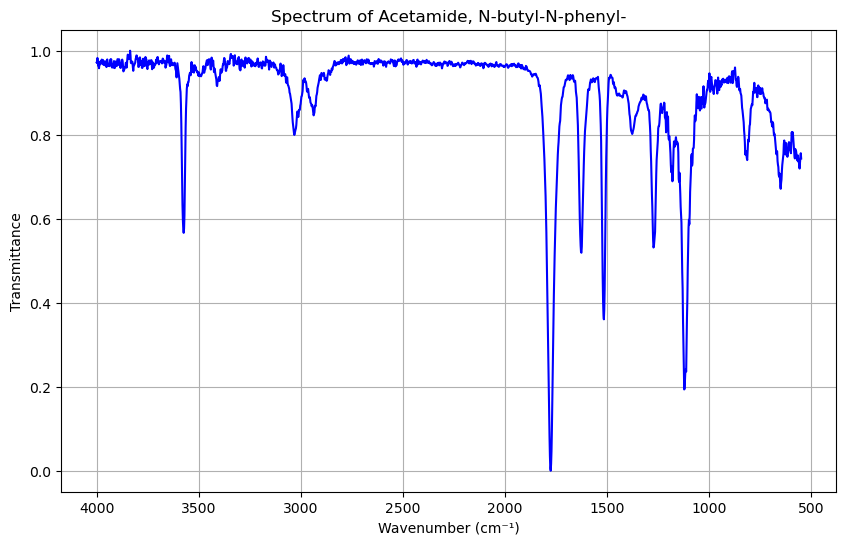

Molecule 7001:
Name: Acetamide, N-butyl-N-phenyl-
ID: 8160
Names: ['carboxylic acid deriv. ', 'carboxylic acid amide ', 'carboxylic acid tert. amide ', 'alkyne ']
--------------------------------------------------


In [23]:
# Plot spectra for all molecules in the dataset
i = 7000
spectrum = dataset[i]
plot_spectrum(spectrum['x_values'], spectrum['y_values'],
                title=f"Spectrum of {spectrum['name']}")
print(f"Molecule {i+1}:")
print(f"Name: {spectrum['name']}")
print(f"ID: {spectrum['id']}")
print(f"Names: {spectrum['functional_groups']}")
print("-" * 50)


Common wavelength range: 1234.23 to 15.98
Standardized 7758 spectra to 1000 points each


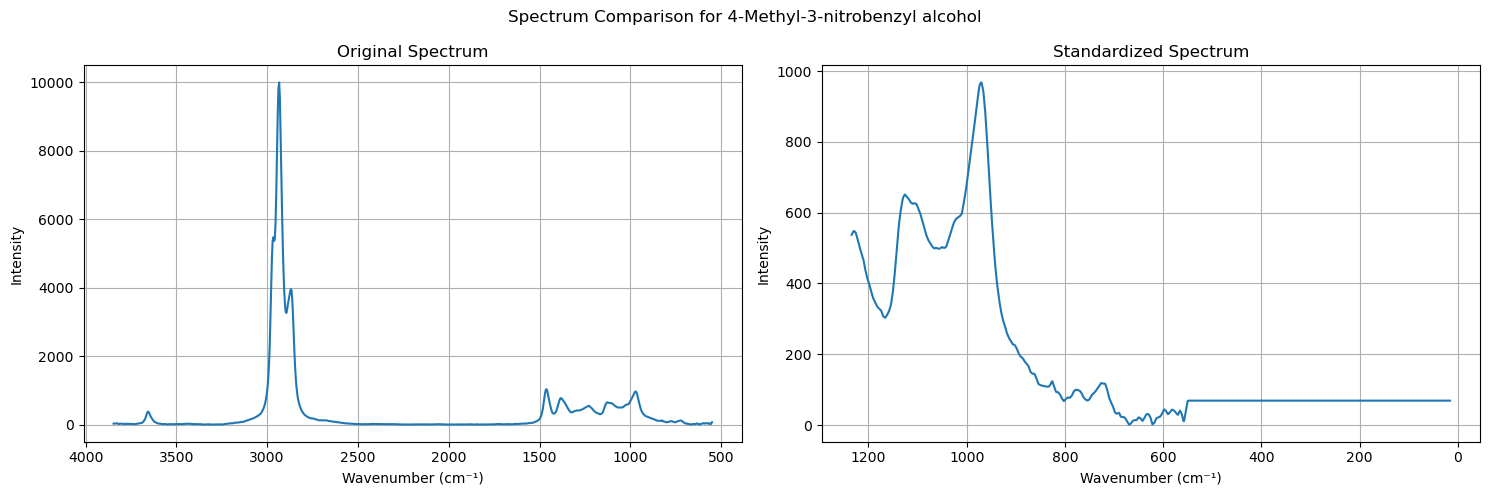

In [24]:
def standardize_spectra(dataset, num_points=1000):
    """
    Standardize all spectra in the dataset to have the same number of points
    and wavelength range.
    
    Args:
        dataset: List of dictionaries containing spectrum data
        num_points: Number of points in the standardized spectra
    
    Returns:
        common_wavelengths: Array of standardized wavelength points
        standardized_dataset: Updated dataset with standardized spectra
    """
    # Find the common wavelength range across all spectra
    min_wavelength = max([min(d['x_values']) for d in dataset])
    max_wavelength = min([max(d['x_values']) for d in dataset])
    
    print(f"Common wavelength range: {min_wavelength:.2f} to {max_wavelength:.2f}")
    
    # Create common wavelength points
    common_wavelengths = np.linspace(min_wavelength, max_wavelength, num_points)
    
    # Create a new dataset with standardized spectra
    standardized_dataset = []
    
    for spectrum in dataset:
        # Interpolate intensities to match common wavelengths
        standardized_intensities = np.interp(
            common_wavelengths,
            spectrum['x_values'],
            spectrum['y_values']
        )
        
        # Create new spectrum dictionary with both original and standardized data
        new_spectrum = spectrum.copy()
        new_spectrum['std_wavelengths'] = common_wavelengths
        new_spectrum['std_intensities'] = standardized_intensities
        
        standardized_dataset.append(new_spectrum)
    
    print(f"Standardized {len(dataset)} spectra to {num_points} points each")
    return common_wavelengths, standardized_dataset

# Standardize the existing dataset
common_wavelengths, standardized_dataset = standardize_spectra(dataset)

# Plot example comparison
i = 5  # Example spectrum index
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original spectrum
ax1.plot(standardized_dataset[i]['x_values'], 
         standardized_dataset[i]['y_values'])
ax1.set_title('Original Spectrum')
ax1.set_xlabel('Wavenumber (cm⁻¹)')
ax1.set_ylabel('Intensity')
ax1.invert_xaxis()
ax1.grid(True)

# Standardized spectrum
ax2.plot(standardized_dataset[i]['std_wavelengths'], 
         standardized_dataset[i]['std_intensities'])
ax2.set_title('Standardized Spectrum')
ax2.set_xlabel('Wavenumber (cm⁻¹)')
ax2.set_ylabel('Intensity')
ax2.invert_xaxis()
ax2.grid(True)

plt.suptitle(f"Spectrum Comparison for {standardized_dataset[i]['name']}")
plt.tight_layout()
plt.show()

Total number of unique functional groups: 106

Example functional groups and their indices:
0: 1,2-aminoalcohol 
1: 1,2-diol 
2: 1,2-diphenol 
3: CO2 deriv. (general) 
4: acetal 
5: acyl bromide 
6: acyl chloride 
7: acyl halide 
8: alcohol 
9: aldehyde 

Label statistics:
1,2-aminoalcohol : 7.0 molecules
1,2-diol : 3.0 molecules
1,2-diphenol : 2.0 molecules
CO2 deriv. (general) : 1.0 molecules
acetal : 3.0 molecules
acyl bromide : 1.0 molecules
acyl chloride : 8.0 molecules
acyl halide : 9.0 molecules
alcohol : 113.0 molecules
aldehyde : 18.0 molecules
alkene : 22.0 molecules
alkyl bromide : 34.0 molecules
alkyl chloride : 44.0 molecules
alkyl fluoride : 8.0 molecules
alkyl iodide : 3.0 molecules
alkylarylether : 76.0 molecules
alkylthiol : 5.0 molecules
alkyne : 538.0 molecules
alpha-aminoacid : 2.0 molecules
aminal : 4.0 molecules
amine : 102.0 molecules
aromatic compound : 134.0 molecules
aryl bromide : 30.0 molecules
aryl chloride : 88.0 molecules
aryl fluoride : 50.0 molecules
ar

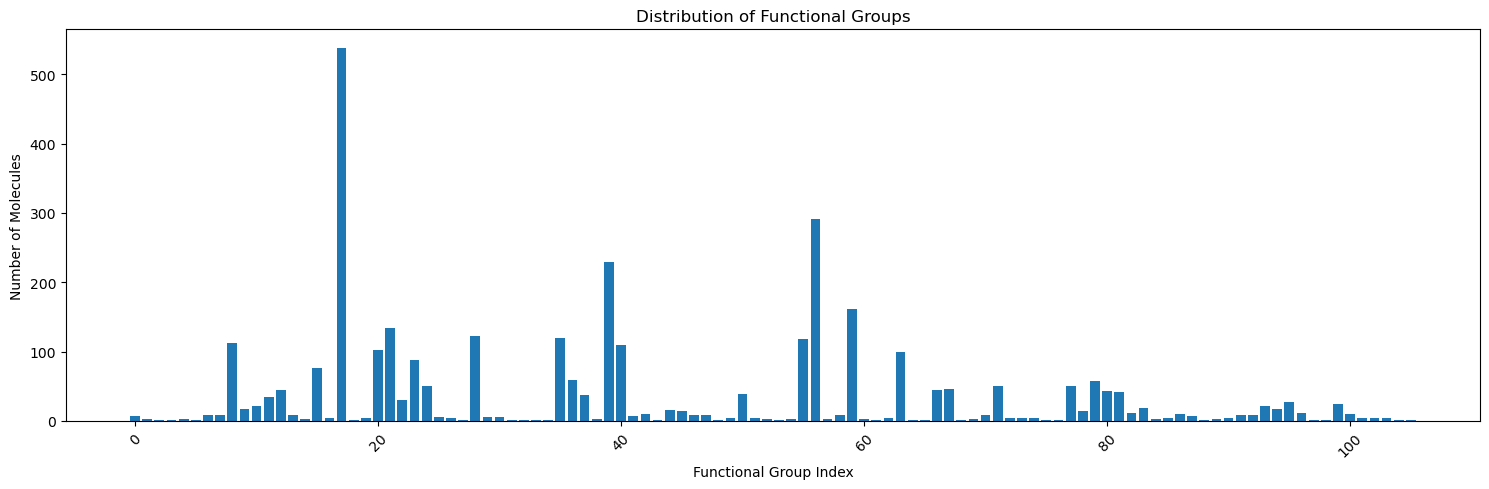


Example molecule (3-Methylbenzyl alcohol):
Present functional groups:
- alcohol 
- alkyne 
- hydroxy compound 
- prim. alcohol 


In [17]:
def create_fg_labels(dataset):
    """
    Create binary labels for functional groups across all molecules.
    
    Args:
        dataset: List of dictionaries containing molecule data
    
    Returns:
        fg_dict: Dictionary mapping functional groups to indices
        label_vectors: Array of binary labels for each molecule
        updated_dataset: Dataset with added label vectors
    """
    # Collect all unique functional groups
    all_fg = set()
    for item in dataset:
        all_fg.update(item['functional_groups'])
    
    # Create a sorted dictionary of functional groups to indices
    fg_dict = {fg: idx for idx, fg in enumerate(sorted(all_fg))}
    print(f"Total number of unique functional groups: {len(fg_dict)}")
    
    # Create binary label vectors for each molecule
    label_vectors = []
    for item in dataset:
        # Initialize zero vector
        labels = np.zeros(len(fg_dict))
        # Set 1s for present functional groups
        for fg in item['functional_groups']:
            labels[fg_dict[fg]] = 1
        label_vectors.append(labels)
    
    # Create updated dataset with label vectors
    updated_dataset = []
    for item, labels in zip(dataset, label_vectors):
        new_item = item.copy()
        new_item['fg_labels'] = labels
        updated_dataset.append(new_item)
    
    # Print example
    print("\nExample functional groups and their indices:")
    for fg, idx in list(fg_dict.items())[:10]:  # Show first 10
        print(f"{idx}: {fg}")
    
    return fg_dict, np.array(label_vectors), updated_dataset

# Create labels and update dataset
fg_dictionary, all_labels, labeled_dataset = create_fg_labels(standardized_dataset)

# Print statistics
print("\nLabel statistics:")
fg_counts = all_labels.sum(axis=0)
for fg, idx in fg_dictionary.items():
    print(f"{fg}: {fg_counts[idx]} molecules")

# Visualize label distribution
plt.figure(figsize=(15, 5))
plt.bar(range(len(fg_dictionary)), fg_counts)
plt.xlabel('Functional Group Index')
plt.ylabel('Number of Molecules')
plt.title('Distribution of Functional Groups')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Example of accessing data for a single molecule
i = 0  # First molecule
print(f"\nExample molecule ({labeled_dataset[i]['name']}):")
print("Present functional groups:")
for fg, idx in fg_dictionary.items():
    if labeled_dataset[i]['fg_labels'][idx] == 1:
        print(f"- {fg}")

In [18]:
i = 8
print(labeled_dataset[i]['name'])
print(labeled_dataset[i]['fg_labels'])
print(labeled_dataset[i]['functional_groups'])

Sulfur Dioxide
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[]


In [20]:
# Convert dataset to tensors and save
all_x_values = []
all_y_values = []
all_labels = []

all_x_values.append(torch.tensor(labeled_dataset[0]['std_wavelengths'], dtype=torch.float32))

for item in labeled_dataset:
    all_y_values.append(torch.tensor(item['std_intensities'], dtype=torch.float32))
    all_labels.append(torch.tensor(item['fg_labels'], dtype=torch.float32))

# Stack tensors
X = torch.stack(all_x_values)
Y = torch.stack(all_y_values)
labels = torch.stack(all_labels)

"""
# Save tensors
torch.save(X, 'spectra_x.pt')
torch.save(Y, 'spectra_y.pt') 
torch.save(labels, 'labels.pt')
"""
print(f"Saved tensors with shapes:")
print(f"X: {X.shape}")
print(f"Y: {Y.shape}")
print(f"labels: {labels.shape}")


Saved tensors with shapes:
X: torch.Size([1, 1000])
Y: torch.Size([1000, 1000])
labels: torch.Size([1000, 106])


/tmp/ipykernel_31022/2859119515.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  wavelengths = np.array(wavelengths)
/tmp/ipykernel_31022/2859119515.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  intensities = np.array(intensities)  # Ensure it's a numpy array


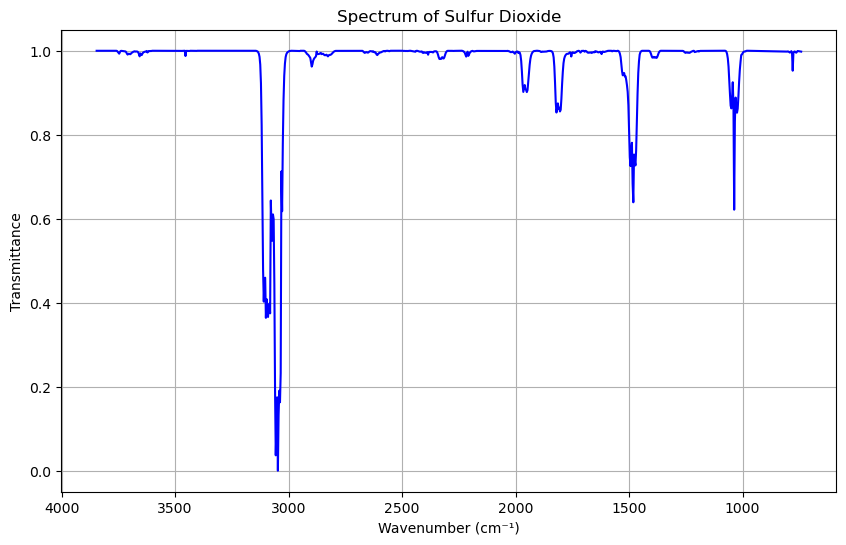

In [23]:
# Export labeled dataset to a file for later use
import pickle

dataset_export = {
    'wavelengths': X,
    'intensities': Y, 
    'labels': labels,
    'fg_dictionary': fg_dictionary,
    'metadata': [
        {
            'name': item['name'],
            'functional_groups': item['functional_groups']
        }
        for item in labeled_dataset
    ]
}

with open('labeled_dataset.pkl', 'wb') as f:
    pickle.dump(dataset_export, f)

print("Exported labeled dataset to labeled_dataset.pkl")


# To import the saved dataset:
# with open('labeled_dataset.pkl', 'rb') as f:
#     dataset = pickle.load(f)
# 
# This will give you:
# - dataset['wavelengths'] : Tensor of wavelength values
# - dataset['intensities'] : Tensor of intensity values  
# - dataset['labels'] : Tensor of functional group labels
# - dataset['fg_dictionary'] : Dictionary mapping functional groups to indices
# - dataset['metadata'] : List of dictionaries with molecule names and functional groups
